In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pymbar import timeseries
from time import time

import sys
sys.path.append("../analysis_scripts/")
from misc_tools import bootstrap_estimates
sys.path.append("../simulation_scripts/")
from sample_ideal_mixing import create_ideal_system

In [2]:
nattempts = 1       # The number of attempts per iteration
deltamus = np.array([-1.0, -0.5, 0.0, 0.5, 1.0, 1.5])    # The chemical potentials that will be applied
niterations = 10000                     # The number of iterations where nattempts are made and statistics recorded.
protocol_work = np.zeros((len(deltamus), niterations)) 
nsalt = np.zeros((len(deltamus), niterations))
nwater = np.zeros((len(deltamus), niterations))


# Statistics of ideal mixing
This notebook validates the `SaltSwap` code by sampling ideal mixing. Ideal mixing is implemented by giving Na$^+$ and Cl$^-$ the same non-bonded parameters as the water model, such that the protocol work to tramsute salt to water is zero. For ideal mixing, the ratio of reactants and products is given by the stoichiometry of the reaction. As the alchemical reaction implemented by the osmostat converts 2 water molecules into one salt pair, the ratio of water molecules to salt pairs is given by

$$ \frac{N_\mathrm{NaCl}}{N_\mathrm{H_2O}} = \exp\left(-\frac{1}{2}\beta\Delta \mu\right) $$

where $\beta\Delta \mu$ is the applied (dimentionless) difference in chemical potential between water and salt

Testing the agreement of `Saltswap` with the above will be achieved by recording the average ratio of the number of water molecules to anion-cation pairs during simulations at a range of different chemical potentials.

## Collect statistics of salt and water numbers for different chemical potentials

In [3]:
nattempts = 1       # The number of attempts per iteration
deltamus = np.array([-1.0, -0.5, 0.0, 0.5, 1.0, 1.5])    # The chemical potentials that will be applied
niterations = 10000                     # The number of iterations where nattempts are made and statistics recorded.
protocol_work = np.zeros((len(deltamus), niterations)) 
nsalt = np.zeros((len(deltamus), niterations))
nwater = np.zeros((len(deltamus), niterations))

t0 = time()
for i in range(len(deltamus)):
    context, ncmc_swapper, langevin = create_ideal_system(npert=1, deltachem=float(deltamus[i]))
    ratio = []
    for iteration in range(niterations):
        # Peform a ideal exchange
        ncmc_swapper.update(context, nattempts=nattempts)
        # Record the protocol work
        protocol_work[i, iteration] = ncmc_swapper.cumulative_work[-1]
        # Record the number of salt and water molecules
        nw, nc, na = ncmc_swapper.get_identity_counts()
        nsalt[i, iteration] = nc
        nwater[i, iteration] = nw
print('Data collection for ideal mixing took {0:.1f} minutes'.format((time() - t0)/60.0))

Data collection for ideal mixing took 34.4 minutes


## Estimate the mean ratio of water to salt
The statistical error will be estimated using the `pymbar` `timeseries` module and bootstrap sampling of approximately independent samples.

Timeseries analysis and estimation of the mean water to salt ratio: 50.1 seconds


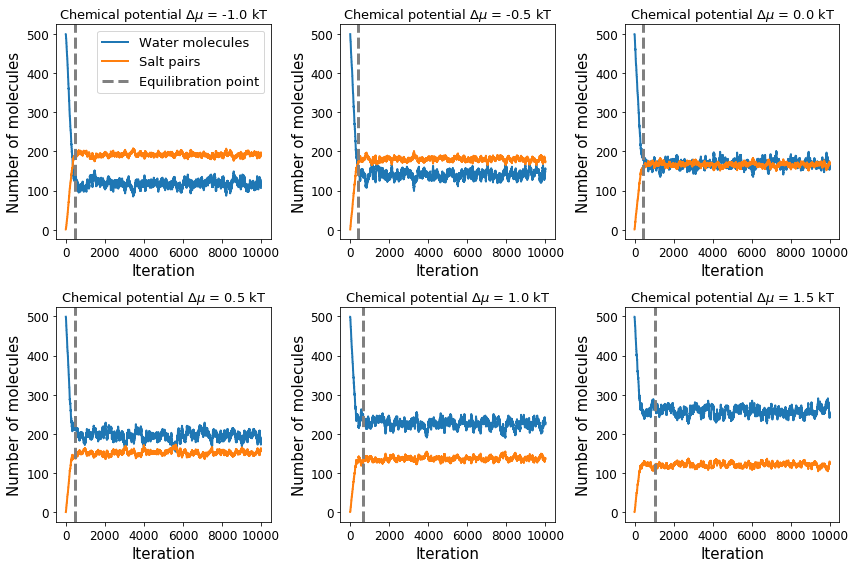

In [4]:
iters = np.arange(1,niterations+1)

ratio_mean = np.zeros(len(deltamus))
error_lower = np.zeros(len(deltamus))
error_upper = np.zeros(len(deltamus))

fig, ax = plt.subplots(2, 3, figsize=(12, 8))

wat_color = 'C0'
salt_color = 'C1'

def set_tick_label_size(ax, size=12):
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(12)

ax_coords = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2)]
t0 = time()
# Discard initial samples, and calculate bootstrap estmate the mean with subsampling. 
for i in range(len(deltamus)):
    # Water
    ax[ax_coords[i]].plot(iters, nwater[i, :], color=wat_color, lw=2, label='Water molecules')
    t_equil, stat_ineff, n_eff = timeseries.detectEquilibration(nwater[i, :], fast=True)
    nwater_equil = nwater[i, t_equil:]
    independent_inds = timeseries.subsampleCorrelatedData(nwater_equil, g=stat_ineff, conservative=True)
    nwater_mean_samps = bootstrap_estimates(nwater_equil[independent_inds])
    
    # Salt
    ax[ax_coords[i]].plot(iters, nsalt[i, :], color=salt_color, lw=2, label='Salt pairs')
    t_equil, stat_ineff, n_eff = timeseries.detectEquilibration(nsalt[i, :], fast=True)
    ax[ax_coords[i]].axvline(t_equil, color='grey', ls='--', lw=3, label='Equilibration point')
    nsalt_equil = nsalt[i, t_equil:]
    independent_inds = timeseries.subsampleCorrelatedData(nsalt_equil, g=stat_ineff, conservative=True)
    nsalt_mean_samps = bootstrap_estimates(nsalt_equil[independent_inds])
    
    # Calculate ratio of mean water to mean salt, and get 95% error bars
    ratios =  nsalt_mean_samps / nwater_mean_samps
    ratio_mean[i] = np.mean(ratios)
    error_lower[i] = ratio_mean[i] - np.percentile(ratios, 2.5)
    error_upper[i] = np.percentile(ratios, 97.5) - ratio_mean[i]
    
    # Plotting details
    ax[ax_coords[i]].set_xlabel('Iteration', fontsize=15)
    ax[ax_coords[i]].set_ylabel('Number of molecules', fontsize=15)
    ax[ax_coords[i]].set_title('Chemical potential $\Delta\mu$ = {0} kT'.format(deltamus[i]), fontsize=13)
    set_tick_label_size(ax[ax_coords[i]], 12)
print('Timeseries analysis and estimation of the mean water to salt ratio: {0:.1f} seconds'.format(time() - t0))

ax[ax_coords[0]].legend(fontsize=13)

plt.tight_layout()
plt.show()

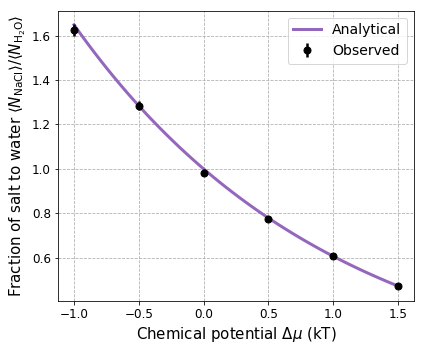

In [16]:
# Calculate the analytical ratio for ideal mixing.
x = np.linspace(deltamus.min(), deltamus.max())
analytical_ratio = np.exp(-x / 2.0)

# Plot!
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(x, analytical_ratio, color='C4', lw=3, label='Analytical')
ax.errorbar(deltamus, ratio_mean, yerr=[error_lower, error_upper], fmt='o', color='black', label='Observed', lw=2.5, zorder=3, markersize=7)
ax.set_xlabel('Chemical potential $\Delta\mu$ (kT)', fontsize=15)
ax.set_ylabel('Fraction of salt to water '+ r'$\langle N_\mathrm{NaCl} \rangle / \langle N_\mathrm{H_2O}\rangle$', fontsize=15)
ax.legend(fontsize=14)
ax.grid(ls='--')

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(12)

plt.savefig('Ideal_mixing_ratios.png', dpi=300)
plt.tight_layout()
plt.show()

## Checking the protocol work
The protocol work should be exactly zero for ideal mixing, although limits to numerical precision means this cannot be achieved in practise. Instead, one should aim for the magnitude of the protocol work to be as small as possible.

In [17]:
print('Mean protocol work = {0} kT, with 95% of samples between {1} kT and {2} kT'.format(protocol_work.mean(), np.percentile(protocol_work, 2.5),  np.percentile(protocol_work, 97.5)))
print('Maximum absolute value of protocol work = {0} kT'.format(np.max(np.abs(protocol_work))))

Mean protocol work = 1.2673133015513282e-07 kT, with 95% of samples between -3.058680534717607e-05 kT and 3.058680534717607e-05 kT
Maximum absolute value of protocol work = 7.340833283322256e-05 kT
